# Notebook for Pipeline

We present the whole pipeline of our methods in this jupyter notebook file other than data analysis.


## Before We Go

### Connect to Google Drive (Optional)

> Note: We suppose that this code is executing on the Google Colab platform. The following code is used to import the libraries we need.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Libraries
    
Please run the following code to import the libraries we need.

In [ ]:
import os
from tqdm import tqdm
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

## Data

Details of the analysis data can be found in `EDA.ipynb`. We will not repeat them here.

> Note: We cannot upload the original data file to the github repository because of copyright issues.

### Dataset

We need to define the dataset class to load the data. The dataset class is defined as follows.

In [ ]:
class SunlightDataset(Dataset):
    def __init__(self, features, labels, window_size=2, step_size=1):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)
        self.window_size = window_size
        self.step_size = step_size

    def __len__(self):
        total_steps = len(self.features) - self.window_size + 1
        # Calculate the number of complete windows that can be formed
        if total_steps > 0:
            return (total_steps + self.step_size - 1) // self.step_size
        else:
            return 0

    def __getitem__(self, index):
        start = index * self.step_size
        end = start + self.window_size

        return (self.features[start:end], self.labels[start:end])

> Note: The data is stored in the Google Drive. If you want to run the code, please change the path to your own path.

In [ ]:
# data = pd.read_csv('/content/drive/MyDrive/data10.csv')
data = pd.read_csv('/content/drive/MyDrive/data17.csv')

In [ ]:
features = data.drop('amount', axis=1)
labels = data['amount']

In [ ]:
features_train, features_val, labels_train, labels_val = train_test_split(features, labels, test_size=0.2, random_state=42)

In [ ]:
train_dataset = SunlightDataset(features_train, labels_train)
val_dataset = SunlightDataset(features_val, labels_val)

In [ ]:
len(train_dataset), len(val_dataset)

(9291, 2323)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
print(train_dataset[0])
print(train_dataset[0][0].shape)
print(train_dataset[0][1].shape)

(tensor([[ 12.4674,  50.0222, 350.0445,  16.4429,   3.9464,  35.9214,  15.0000,
         871.3664,  59.4757,  64.0198,  63.7542,  52.5091],
        [ 97.0000,  61.0000, 296.0000,  16.3133,   0.0000, -36.0814,  21.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000]]), tensor([77.,  0.]))
torch.Size([2, 12])
torch.Size([2])


In [ ]:
train_features, train_labels = next(iter(train_loader))
print(train_features.shape)
print(train_labels.shape)

torch.Size([64, 2, 12])
torch.Size([64, 2])


## Model

We should define the model class to train the model.

> Note: Before defining the model class, please install related packages to ensure that the code can run normally.

In [ ]:
!pip install transformers

In [ ]:
import torch
import torch.nn as nn

from transformers.models.bert.modeling_bert import BertConfig, BertEncoder, BertModel

### LSTM with Attention

We use the LSTM with Attention model to train the data. 

We implement not only the LSTM model but also Attention mechanism for making the model keep the long-term dependency and focus on the important part of the data.

In [ ]:
class LSTMwithAttn(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, num_heads=8, dropout=0.1, device='cpu'):
        super(LSTMwithAttn, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.dropout = dropout
        self.device = device

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        self.config = BertConfig(
            hidden_size=hidden_dim,
            num_hidden_layers=num_layers,
            num_attention_heads=num_heads,
            intermediate_size=hidden_dim,
            hidden_dropout_prob=dropout,
            attention_probs_dropout_prob=dropout,
        )
        self.encoder = BertEncoder(self.config)

        self.act = nn.SiLU()
        self.fc = nn.Linear(hidden_dim, output_dim)

        self.init_weights()


    def init_hidden_state(self, batch_size):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(self.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(self.device)
        return (h0, c0)


    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)


    def generate_attn_mask(self, x):
        seq_len = x.size(1)
        attn_mask = torch.tril(torch.ones((seq_len, seq_len))).view(1, seq_len, seq_len).to(self.device)

        return attn_mask


    def forward(self, x):
        batch_size = x.size(0)

        h0, c0 = self.init_hidden_state(batch_size)

        output, (hidden, cell) = self.lstm(x, (h0, c0))

        output = output.contiguous().view(batch_size, -1, self.hidden_dim)

        # Attention Mask
        attn_mask = self.generate_attn_mask(x)
        extended_attn_mask = attn_mask[None, :, :, :].expand(batch_size, -1, -1, -1)
        extended_attn_mask = (1.0 - extended_attn_mask) * -10000.0

        encoder_outputs = self.encoder(output, attention_mask=extended_attn_mask)

        output = self.act(encoder_outputs.last_hidden_state)
        output = self.fc(output)

        return output

> Note: We suppose that this code is running with GPU.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Training

Below is the code for training the model.

In [ ]:
model = LSTMwithAttn(input_dim=12, hidden_dim=64, output_dim=1, num_layers=2, device=device)

In [ ]:
model = model.to(device)

In [ ]:
LEARNING_RATE = 0.001
EPOCHS = 100
WEIGHT_DECAY = 0.01
EARLY_STOPPING = 5

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [ ]:
criterion = nn.MSELoss(reduction='mean')

In [ ]:
train_losses = []
val_losses = []

loss = .0
best_val_loss = float('inf')
increasing_loss_count = 0

> Note: If we test the model without any training, initial loss would be very large.

In [ ]:
model.eval()

with torch.no_grad():
    for features, labels in val_loader:
        features = features.to(device)
        labels = labels.to(device)

        outputs = model(features)

        _loss = criterion(outputs.squeeze(-1), labels)

        loss += _loss.item()

print(f'Initial Loss: {loss/len(val_loader):.4f}')

Initial Loss: 927.3455


> Note: We can realize that the loss is decreasing as the training goes on. We also employ the early stopping mechanism to prevent overfitting.

In [ ]:
train_losses = []
val_losses = []

for i in range(EPOCHS):
    print("=" * 30)
    print(f"Current Epoch {i+1}")
    print("=" * 30)
    print("Training...")
    train_loss = .0

    model.train()
    for features, labels in tqdm(train_loader, leave=False):
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(features)

        _loss = criterion(outputs.squeeze(-1), labels)
        _loss.backward()
        optimizer.step()

        train_loss += _loss.item()


    print("Evaluating...")
    val_loss = .0

    model.eval()

    for features, labels in tqdm(val_loader, leave=False):
        features = features.to(device)
        labels = labels.to(device)

        outputs = model(features)

        _loss = criterion(outputs.squeeze(-1), labels)

        val_loss += _loss.item()

    train_losses += [train_loss/len(train_loader.dataset)]
    epoch_val_loss = val_loss/len(val_loader.dataset)
    val_losses += [epoch_val_loss]
    print(f"Epoch #{i+1}: [Training MSE/Evaluation MSE]: [{train_loss/len(train_loader.dataset):.4f}/{val_loss/len(val_loader.dataset):.4f}]")

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        increasing_loss_count = 0
    else:
        increasing_loss_count += 1

    if increasing_loss_count >= EARLY_STOPPING:
        print("Early Stopping!")
        break


Current Epoch 1
Training...


Evaluating...


Epoch #1: [Training MSE/Evaluation MSE]: [11.1684/8.8483]
Current Epoch 2
Training...


Evaluating...


Epoch #2: [Training MSE/Evaluation MSE]: [7.6035/5.7478]
Current Epoch 3
Training...


Evaluating...


Epoch #3: [Training MSE/Evaluation MSE]: [4.8676/3.6279]
Current Epoch 4
Training...


Evaluating...


Epoch #4: [Training MSE/Evaluation MSE]: [3.2676/2.4581]
Current Epoch 5
Training...


Evaluating...


Epoch #5: [Training MSE/Evaluation MSE]: [2.4687/1.9070]
Current Epoch 6
Training...


Evaluating...


Epoch #6: [Training MSE/Evaluation MSE]: [2.0526/1.6590]
Current Epoch 7
Training...


Evaluating...


Epoch #7: [Training MSE/Evaluation MSE]: [1.8574/1.5639]
Current Epoch 8
Training...


Evaluating...


Epoch #8: [Training MSE/Evaluation MSE]: [1.7468/1.5302]
Current Epoch 9
Training...


Evaluating...


Epoch #9: [Training MSE/Evaluation MSE]: [1.6635/1.6135]
Current Epoch 10
Training...


Evaluating...


Epoch #10: [Training MSE/Evaluation MSE]: [1.6023/1.6105]
Current Epoch 11
Training...


Evaluating...


Epoch #11: [Training MSE/Evaluation MSE]: [1.5996/1.4938]
Current Epoch 12
Training...


Evaluating...


Epoch #12: [Training MSE/Evaluation MSE]: [1.5272/1.3718]
Current Epoch 13
Training...


Evaluating...


Epoch #13: [Training MSE/Evaluation MSE]: [1.5114/1.3984]
Current Epoch 14
Training...


Evaluating...


Epoch #14: [Training MSE/Evaluation MSE]: [1.4987/1.4251]
Current Epoch 15
Training...


Evaluating...


Epoch #15: [Training MSE/Evaluation MSE]: [1.4898/1.3739]
Current Epoch 16
Training...


Evaluating...


Epoch #16: [Training MSE/Evaluation MSE]: [1.4571/1.3713]
Current Epoch 17
Training...


Evaluating...


Epoch #17: [Training MSE/Evaluation MSE]: [1.4863/1.4351]
Current Epoch 18
Training...


Evaluating...


Epoch #18: [Training MSE/Evaluation MSE]: [1.4920/1.4622]
Current Epoch 19
Training...


Evaluating...


Epoch #19: [Training MSE/Evaluation MSE]: [1.4351/1.3644]
Current Epoch 20
Training...


Evaluating...


Epoch #20: [Training MSE/Evaluation MSE]: [1.4385/1.3615]
Current Epoch 21
Training...


Evaluating...


Epoch #21: [Training MSE/Evaluation MSE]: [1.4157/1.3602]
Current Epoch 22
Training...


Evaluating...


Epoch #22: [Training MSE/Evaluation MSE]: [1.4225/1.4581]
Current Epoch 23
Training...


Evaluating...


Epoch #23: [Training MSE/Evaluation MSE]: [1.4153/1.3890]
Current Epoch 24
Training...


Evaluating...


Epoch #24: [Training MSE/Evaluation MSE]: [1.4065/1.3953]
Current Epoch 25
Training...


Evaluating...


Epoch #25: [Training MSE/Evaluation MSE]: [1.4080/1.4099]
Current Epoch 26
Training...


Evaluating...


Epoch #26: [Training MSE/Evaluation MSE]: [1.3828/1.4477]
Early Stopping!


In [ ]:
%matplotlib inline

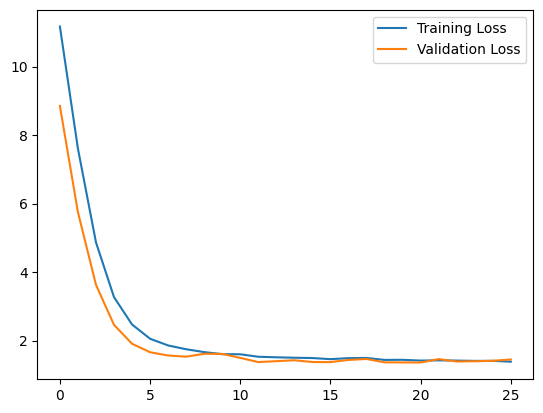

In [ ]:
plt.plot(range(len(train_losses)), train_losses, label="Training Loss")
plt.plot(range(len(val_losses)), val_losses, label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
directory = 'models'
os.makedirs(directory, exist_ok=True)

In [ ]:
torch.save(model.state_dict(), 'models/model.pt')

## Inference

The code below is used to inference the model and submit the result to the competition.

In [ ]:
# Load the model

model.load_state_dict( torch.load('models/model.pt') )
model.to(device)

In [ ]:
# testdata = pd.read_csv('/content/drive/MyDrive/data/Tdata10.csv')
testdata = pd.read_csv('/content/drive/MyDrive/data/Tdata17.csv')

In [ ]:
features_test = testdata
labels_test = pd.DataFrame({'label': [0] * len(testdata)})
test_dataset = SunlightDataset(features_test, labels_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# get number of rows in testdata
num_test = len(testdata)
num_test

24

In [ ]:
next(iter(test_loader))[0].shape

torch.Size([1, 2, 12])

In [ ]:
y_pred = [[] for _ in range(num_test)]
len(y_pred)

24

In [ ]:
# test phase
model.eval()

with torch.no_grad():
    for i, (features, labels) in enumerate(test_loader):
        features = features.to(device)
        labels = labels.to(device)

        outputs = model(features).squeeze(-1)
        outputs[outputs < 0] = 0

        for seq_idx in range(outputs.shape[-1]):
            y_pred[i + seq_idx].append(outputs[:,seq_idx].item())

In [ ]:
y_pred = [sum(y_pred[i]) / len(y_pred[i]) for i in range(len(y_pred))]

In [ ]:
y_pred_pd = pd.DataFrame(y_pred)
y_pred_pd.to_csv('solar.csv', index=False)